# Stage 2020-2021

# Active Learning appliqué aux films conducteurs transparents 

## 1- Importation des bibliothèques nécessaires 

### a) Bibliothèques usuelles

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

### b) Bibliothèques du Machine Learning

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

### c) Bibliothèques de l'Active Learning

In [3]:
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.uncertainty import uncertainty_sampling
from modAL.disagreement import max_std_sampling

## 2- Importation des données 

In [4]:
data = pd.read_table("C:/Users/salma/OneDrive/Bureau/Stage 2020-2021/Machine Learning/Publications/Electrode_publication/Data/DOE(GSD)_1stRUN_avec32.data", sep=',')
data

,Set,Cu_content,Temperature (°C),Time (min),EDTA,FoM (μS),no.of samples
0,1,0.65,60,30,0.02,138.0,3
1,2,0.65,60,60,0.03,178.0,3
2,3,0.65,60,90,0.07,110.0,3
3,4,0.65,60,120,0.10,148.0,3
4,5,0.65,70,30,0.03,193.0,3
5,6,0.65,70,60,0.07,184.0,3
6,7,0.65,70,90,0.10,18.2,3
7,8,0.65,70,120,0.02,32.8,3
8,9,0.65,80,30,0.07,54.0,3
9,10,0.65,80,60,0.10,35.2,3


In [5]:
data.shape

(32, 7)

**a)** On sépare les facteurs et la variable cible.

In [6]:
X = data[["Cu_content",'Temperature (°C)','Time (min)','EDTA']]
Y = data['FoM (μS)']

on transforme le dataframe en une matrice (numpy)

In [7]:
X_raw=X.to_numpy()
Y_raw=Y.to_numpy()

**b)** On choisit les premières instances étiquetées  

In [8]:
racine = 0
n_initial = X_raw.shape[0] 
size = 15
random.seed(racine)
lab_indices =  random.sample(range(n_initial), size)
print(lab_indices)

[24, 31, 28, 13, 1, 8, 16, 15, 12, 9, 30, 11, 18, 6, 25]


In [9]:
# Les données étiquetées.
X_lab = X_raw[lab_indices]
Y_lab = Y_raw[lab_indices] 

In [10]:
# Les données non-étiquetées.
X_unlab = np.delete(X_raw, lab_indices, axis=0) 
Y_unlab = np.delete(Y_raw, lab_indices, axis=0)

## 3- L'apprenant  

### 3.1- Avec 4 apprenants en utilisant le committee

Pour créer un objet ActiveLearner, on doit fournir deux choses : un objet estimateur scikit-learn et une fonction de stratégie d'interrogation (cette dernière est optionnelle, la stratégie par défaut est l'échantillonnage à incertitude maximale). En ce qui concerne les stratégies d'interrogation, on peut trouver des modules intégrés dans modAL.uncertainty, mais on peut aussi implémenter les notres.

In [11]:
learner_list = [ActiveLearner(
                        estimator=RandomForestRegressor(random_state = idx+racine),
                        X_training=X_lab, y_training=Y_lab,
                )
                for idx in range(4)]

L'une des stratégies d'apprentissage actif les plus populaires est **la requête par comité** , où nous conservons plusieurs hypothèses (c'est-à-dire des classificateurs entraînés) sur les données, et nous sélectionnons nos requêtes en mesurant le désaccord des hypothèses. En modAL, ce modèle est implémenté dans la classe **Comité**.

Pour créer un objet Comité, vous devez fournir deux choses : une liste d'objets ActiveLearner et une fonction de stratégie de requête . (Une liste d' estimateurs scikit-learn ne suffira pas, car chaque apprenant doit garder une trace des exemples de formation qu'il a vus.) Par exemple, vous pouvez procéder comme suit.

In [12]:
# Le Committee
committee = CommitteeRegressor(
    learner_list=learner_list,
    query_strategy=max_std_sampling
)

In [13]:
# Prédiction de chaque apprenant
for learner_idx, learner in enumerate(committee):
    print('learner no %d : \n'  % (learner_idx + 1) , learner.predict(X))

learner no 1 : 
 [ 81.983 134.586  61.83   44.752  98.073  51.383  29.186  84.923  45.842
  31.9    92.187  80.448  21.003 108.918 126.715  46.796  64.222 116.866
  49.17   39.031  83.592  35.148  28.66   73.869  25.967  27.625  87.558
  81.509  15.901 103.774 124.312  24.276]
learner no 2 : 
 [ 71.92  133.263  56.69   40.954 100.43   50.171  31.055  89.431  46.638
  34.812  87.509  86.547  22.354  96.662 122.969  46.883  59.145 121.17
  47.888  37.357  91.123  37.164  31.878  81.25   29.321  28.326  85.245
  88.521  17.621  93.847 123.275  32.158]
learner no 3 : 
 [ 84.723 148.996  57.604  43.072 109.855  50.703  32.555  98.381  45.955
  33.812  99.441  94.798  20.345 105.283 128.596  42.947  74.094 140.1
  50.852  40.837 101.599  39.129  31.635  88.638  27.159  29.561  94.868
  96.264  15.757  99.298 126.68   23.455]
learner no 4 : 
 [ 78.149 134.603  54.019  39.577 103.786  50.236  32.001  90.947  45.12
  32.02   90.063  84.967  24.329  98.939 125.886  48.099  69.873 126.119
  43.79

In [14]:
# Isolate the data we'll need for plotting.
predictions_init = committee.predict(X)

In [15]:
def score(pred, Y) :
    n = Y.shape[0] 
    err = (1/2*n)*np.sum((Y-pred)**2)
    perf = 1- err 
    return perf

In [16]:
score(predictions_init, Y)

-925391.167022

No handles with labels found to put in legend.


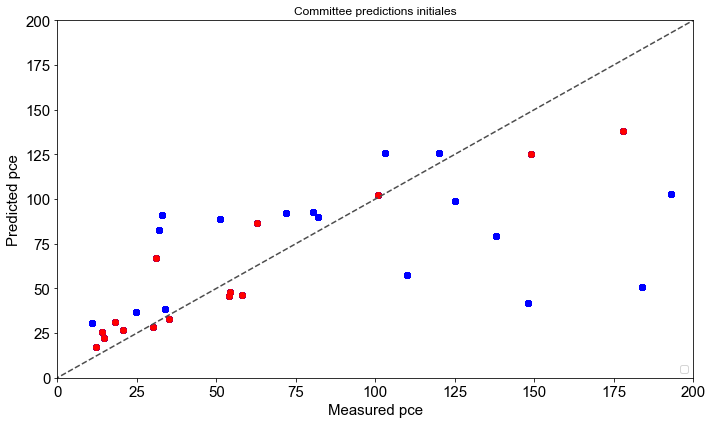

In [17]:
fig, ax1 = plt.subplots(1, 1, clear = True, num = 'Predicted vs Measured pce', figsize=(10, 6))  
prediction = committee.predict(X)
for label, data in data.groupby('Set'):   
    plt.plot(Y, predictions_init, 'bo') 
    plt.plot(Y_lab, predictions_init[lab_indices], 'ro')
plt.title('Committee predictions initiales')
plt.legend(loc='lower right', frameon = True)     
plt.plot([-1, 200], [-1, 200], ls = "--", c = ".3")  
plt.autoscale(enable = False)                    
plt.xlim(0,200)                             
plt.ylim(0,200)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
font = {'size': 15}
ax1.set_xlabel(r'Measured pce', font)
ax1.set_ylabel(r'Predicted pce', font)

plt.style.use('seaborn')                 

plt.tight_layout()                        
plt.show()  

[8]


No handles with labels found to put in legend.


[5]


No handles with labels found to put in legend.


[0]


No handles with labels found to put in legend.


[1]


No handles with labels found to put in legend.


[12]


No handles with labels found to put in legend.


[6]


No handles with labels found to put in legend.


[3]


No handles with labels found to put in legend.


[1]


No handles with labels found to put in legend.


[0]


No handles with labels found to put in legend.


[2]


No handles with labels found to put in legend.


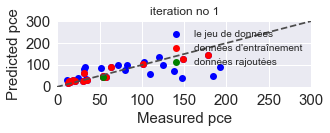

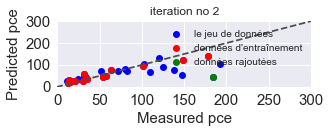

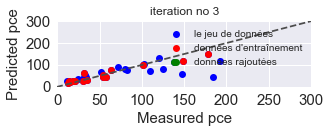

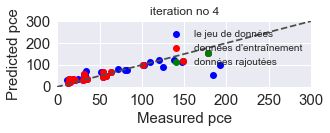

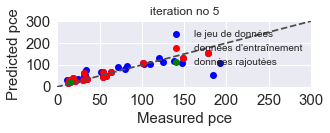

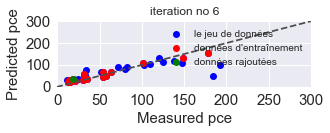

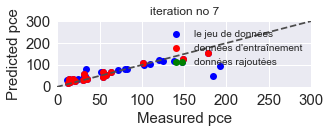

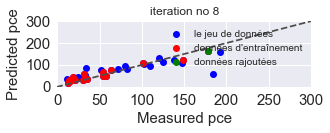

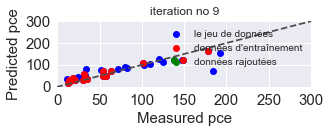

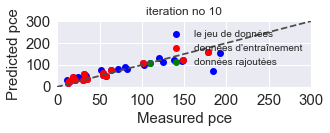

In [18]:
#Active regression 
performance = list()
n_queries= 10
#performance_history = [unqueried_score]
# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(n_queries):
    query_index, query_instance = committee.query(X_unlab)
    print(query_index)
# Teach our ActiveLearner model the record it has requested.
    X_new, Y_new = X_unlab[query_index].reshape(1, -1), Y_unlab[query_index].reshape(1, )
    committee.teach(X=X_new, y=Y_new)
    # Remove the queried instance from the unlabeled pool.
    X_unlab, Y_unlab = np.delete(X_unlab, query_index, axis=0), np.delete(Y_unlab, query_index)
    predictions = committee.predict(X)
    perf = score(predictions, Y)
    performance.append(perf)
    plt.figure(figsize=(10, 7))
    plt.subplot(5,2,index+1)
    for label, data in data.groupby('Set'): 
        p1, = plt.plot(Y, predictions, 'bo')
        #plt.plot(Y_unlab[query_index], )
        p2, = plt.plot(Y_lab, predictions[lab_indices], 'ro')
        p3, = plt.plot(Y[query_index], predictions[query_index], 'go')
        plt.title('iteration no %d' % (index+1))
    plt.legend(loc='upper left', frameon = True)     
    plt.plot([-1, 300], [-1, 300], ls = "--", c = ".3")  
    plt.autoscale(enable = False) 
    plt.legend([p1,p2,p3],["le jeu de données","données d'entraînement","données rajoutées"])
    plt.xlim(0,300)                             
    plt.ylim(0,300)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    font = {'size': 15}
    plt.xlabel(r'Measured pce', font)
    plt.ylabel(r'Predicted pce', font)
    # Mon code ajouté ci-dessous :
    #X_train, Y_train = X_train.extend(X_raw[query_index]), Y_train.extend(Y_raw[query_index])
    # Calculate and report our model's accuracy.
#    model_accuracy = committee1.score(X_raw, Y_raw)
#    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
    # Save our model's performance for plotting.
#    performance_history.append(model_accuracy)

In [1]:
plt.plot(np.arange(10), performance) 

NameError: name 'plt' is not defined

In [20]:
performance

[-960971.8706479999,
 -764265.0862320001,
 -670620.9728780002,
 -577398.6316699999,
 -536304.780311,
 -571655.3730800002,
 -574413.8896590001,
 -437923.0877529998,
 -376766.45449499984,
 -339857.0725240001]